# Libraries

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from utils_soundfields import plot_sf, plot_rir
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker
from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(1234)

# Random number generators in other libraries
np.random.seed(1234)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(device)

if device == 'cuda': 
    print(torch.cuda.get_device_name()) 


cuda


# Tunning Parameters

In [2]:
steps=20000
lr=1e-1
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers
N_u = 100 #Total number of data points for 'u'
N_f = 10_000 #Total number of collocation points 
nu = 0.01/np.pi #diffusion coefficient

plot_rir# Problem Setup
https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks

**2D Wave Equation**

$$\frac{\partial^2 p}{\partial t^2} = c^2 \left( \frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2} \right) \rightarrow$$
$$\frac{\partial^2 p}{\partial x^2} + \frac{\partial^2 p}{\partial y^2}  - \frac{1}{c^2} \frac{\partial^2 p}{\partial t^2} = 0$$

$$x, y \in[-1,1]$$
$$t\in[0,1]$$


# Inverse Problems

**Forward Problem**: Model$→$Data (Predict)

**Inverse Problem**: Data→Model (i.e., actually, we get the Model's parameters)

###Example

(See: https://book.sciml.ai/notes/10/)

A Neural Network is an example of an inverse problem:

1.   We have an unknown model that follows:

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

2.   We use our "training" data to get $W_i$ and $b_i$; for $i=1,2,..\#layers$.


Specifically:

Data → Model i.e., estimate our model parameters (i,e., $W_i$ and $b_i$)




# PINNs for Inverse Problems or "Data-driven Discovery of Nonlinear Partial Differential Equations"

(See: https://arxiv.org/abs/1711.10566)

**Inverse Problem**: Data$→$Model's parameters so:

Data →PINN→ Model Parameters (i.e., our PDE parameters)

For parameterized and nonlinear partial differential equations of the general form (Raissi et al., 2017):

$$p_{tt}+\mathscr{N}[p; c]=0$$

where, $p(\mathbf{r},t)$ is the hidden solution and $\mathscr{N}[p;c]$ is a nonlinear operator.

In short: We will use a PINN to get $p(\mathbf{r}^{\prime},t)$ in positions $\mathbf{r}^{\prime}$.


## Analysis:

Let:

$p_{tt}=\frac{\partial^2 p}{\partial t^2}$

$p_{xx}=\frac{\partial^2 u}{\partial x^2}$
$p_{yy}=\frac{\partial^2 u}{\partial y^2}$

$\mathscr{N}[p;c]=c^2 \left( p_{xx} + p_{yy} \right)$

Our PDE is described as:

$$p_{tt} - c^2 \left( p_{xx} + p_{yy} \right)=0$$

Or,

$$p_{tt} -\mathscr{N}[p]=0$$













## Neural Network

A Neural Network is a function (See:https://book.sciml.ai/notes/03/):

$$N(X)=W_n\sigma_{n-1}(W_{n-1}\sigma_{n-2}(...(W_2(W_1X+b_1)+b_2)+..)+b_{n-1})+b_n$$

**Note:**We usually train our N by iteratively minimizing a loss function in the training dataset(known data) to get $W_i$ and $b_i$.
 
## PINNs=Neural Network + PDE 
(See: https://www.sciencedirect.com/science/article/pii/S0021999118307125)

We can use a neural network to approximate any function (Universal APproximation Theorem): (See:https://book.sciml.ai/notes/03/)
$$N(\mathbf{r},t)\approx u(\mathbf{r},t)$$

Since N(\mathbf{r},t) is a function, we can obtain its derivatives: $\frac{\partial N}{\partial t},\frac{\partial^2 N}{\partial x^2}, etc.$.(Automatic Diferentiation)

Assume:$$N(\mathbf{r}, t)\approx p(\mathbf{r}, t)$$

Then:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right) \approx p_{tt} - c^2 \left(p_{xx} + p_{yy} \right)=0$$

And:

$$N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)\approx 0$$


We define this function as $f$:

$$f(\mathbf{r}, t)=N_{tt} - c^2 \left(N_{xx} + N_{yy} \right)$$

Remember our operator:

$$f(\mathbf{r}, t)=N_t+\mathscr{N}[N,c]$$

So:

$$f(\mathbf{r}, t)\approx 0$$

### PINNs' Loss function

We evaluate $f$ in a certain number of points ($L$) inside our domain $(\mathbf{r},t)$. Then we iteratively minimize a loss function related to $f$:

$$MSE_f=\frac{1}{L}\sum^{L}_{i=1}|f(\mathbf{r}_p^i,t_p^i)|^2$$

Usually, the training data set is a set of points from which we know the answer. In our case, points inside our domain (i.e., interior points). **Remember that this is an inverse problem, so we know the data.**

Since we know the outcome, we select $N$ and compute the $MSE_{\mathbf{r}}$** (compare it to the reference solution).

$$MSE_{\mathbf{r}}=\frac{1}{L}\sum^{L}_{i=1}|p(\mathbf{r}_p^i, t_{p}^i)-N(\mathbf{r}_p^i, t_{p}^i)|^2$$

Please note that $\{\mathbf{r}_p^i, t_{p}^i\}_{i=1}^L$ are the same in $MSE_f$ and $MSE_{\mathbf{r}}$

#### Total Loss:

$$MSE=MSE_{u}+MSE_f$$

NOTE: We minimize $MSE$ to obtain the $N$'s parameters (i.e, $W_i$ and $b_i$) and the PDEs parameters (i.e., $p(\mathbf{r}^{\prime}, t)$)→ We will ask our neural network to find our $p(\mathbf{r}^{\prime})$.

### Neural Network

In [ ]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers, bounds):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
        self.rmax = bounds[0]
        self.tmax = bounds[1]

        if torch.is_tensor(self.upper_bound) != True:
            self.upper_bound = torch.from_numpy(self.upper_bound)
        if torch.is_tensor(self.lower_bound) != True:
            self.lower_bound = torch.from_numpy(self.lower_bound)

        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,input):
        x, y, t = input
        if torch.is_tensor(x) != True:
            x = torch.from_numpy(x)
        if torch.is_tensor(y) != True:
            y = torch.from_numpy(y)
        if torch.is_tensor(t) != True:
            t = torch.from_numpy(t)

        #preprocessing input - feature scaling
        x /= self.rmax
        y /= self.rmax
        t /= self.tmax
        #convert to float
        x = x.float()
        y = y.float()
        t = t.float()

        input_processed = torch.stack((x, y, t), dim=-1).view(-1, 2)

        for i in range(len(layers)-2):
            
            z = self.linears[i](input_processed)
                        
            p_out = self.activation(z)
            
        p_out = self.linears[-1](p_out)
        
        return p_out

In [ ]:
#  PINN
#https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics
class FCN():
    def __init__(self, layers):
        self.loss_function = nn.MSELoss(reduction ='mean')
        'Initialize iterator'
        self.iter = 0
        self.c = 343.
        'Call our DNN'
        self.dnn = DNN(layers).to(device)

    def cylindrical_coords(self, input):
        x,y,t = input
        r = torch.sqrt(x + y)
        phi = torch.atan2(y,x)
        return r, phi


    def loss_data(self,input,pm):
                
        loss_u = self.loss_function(self.dnn(input), pm)
      
        return loss_u
    
    def loss_PDE(self, input):
                        
        g = input.clone()
                        
        g.requires_grad = True
        
        pnet = self.dnn(g)
                
        p_r_t = autograd.grad(pnet,g,torch.ones([input.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        p_rr_tt = autograd.grad(p_r_t,g,torch.ones(input.shape).to(device), create_graph=True)[0]

        p_xx = p_rr_tt[:,[0]]
        p_yy = p_rr_tt[:,[1]]
        p_tt = p_rr_tt[:,[2]]

        f = p_tt - 1/self.c * (p_xx + p_yy)
        
        loss_f = self.loss_function(f,f_hat)
                
        return loss_f

    def loss_bc(self, input):
        # x,y,t = input
        g = input.clone()
        g.requires_grad = True
        r, phi = self.cylindrical_coords(input)
        sin_phi = torch.sin(phi)
        cos_phi = torch.cos(phi)
        pnet = self.dnn(g)
        p_x_y_t = autograd.grad(pnet,g,torch.ones([g.shape[0], 1]).to(device), create_graph=True)[0]
        p_x = p_x_y_t[:,[0]]
        p_y = p_x_y_t[:,[1]]
        dp_dt = p_x_y_t[:,[2]]
        dp_dr = sin_phi*p_y + cos_phi*p_x
        # Sommerfeld conditions
        f = r*(dp_dr + 1/self.c * dp_dt)
        bcs_loss = self.loss_function(f,f_hat)
        return bcs_loss

    def loss(self,input,pm):

        loss_p = self.loss_data(input,pm)
        loss_f = self.loss_PDE(input)
        
        loss_val = loss_p + loss_f
        
        return loss_val



    'callable for optimizer'                                       
    def closure(self, train_input, test_input, p_train, p_test):
        
        optimizer.zero_grad()
        
        loss = self.loss(train_input, p_train)
        
        loss.backward()
                
        self.iter += 1
        
        if self.iter % 100 == 0:

            error_vec, _ = PINN.test(test_input, p_test)
        # TODO: FIX HERE
            print(
                'Relative Error (Test): %.5f' %
                (
                    error_vec.cpu().detach().numpy(),
                )
            )
            

        return loss        
    
    'test neural network'
    def test(self, test_input, p_true):
                
        p_pred = self.dnn(test_input)
        
        error_vec = torch.linalg.norm((p_true-p_pred),2)/torch.linalg.norm(p_true,2)        # Relative L2 Norm of the error (Vector)
        
        p_pred = p_pred.cpu().detach().numpy()
        

        return error_vec, p_pred

In [ ]:
class PINNDataset(Dataset):
    def __init__(self, rirdata, x_true, y_true, t, data_ind, boundary_ind, t_ind, transform=None, target_transform=None, device = 'cuda', batch_size = 300):
        self.transform = transform
        self.target_transform = target_transform
        self.tfnp = lambda x : torch.from_numpy(x).float().to(device)

        # TrainPositions = [tfnp(x_true[data_ind]), tfnp(y_true[data_ind]), tfnp(t[t_ind])]
        # BCPositions = [tfnp(x_true[boundary_ind]), tfnp(y_true[boundary_ind]), tfnp(t[t_ind])]
        # EvalPositions = [tfnp(x_true), tfnp(y_true), tfnp(t[t_ind])]
        self.TrainData = rirdata[data_ind]
        self.BCData = rirdata[boundary_ind]
        # TrainData = tfnp(TrainData[:, t_ind])
        # self.TrainPositions = TrainPositions
        # self.BCPositions = BCPositions
        # self.EvalPositions = EvalPositions
        # self.TrainData = TrainData

        self.t_ind = t_ind
        self.data_ind = data_ind
        self.boundary_ind = boundary_ind
        self.x_true = x_true
        self.y_true = y_true
        self.t = t
        self.batch_size = batch_size
        # self.n_time_instances = int(0.6 * self.batch_size)
        # self.n_spatial_instances = self.batch_size - self.n_time_instances
        self.n_spatial_instances = len(data_ind)
        self.n_time_instances = self.batch_size - self.n_spatial_instances

    def __len__(self):
        # return 1
        return len(self.t_ind)

    def __getitem__(self, idx):
        # data_time_indices = np.random.choice(self.t_ind, self.n_time_instances, replace= False)
        t_batch_indx = self.t_ind[idx]
        t_data = self.t[t_batch_indx]
        pressure_batch = self.TrainData[:, t_batch_indx].flatten()
        pressure_bc_batch = self.BCData[:, t_batch_indx].flatten()
        x_data, y_data = self.x_true[self.data_ind], self.y_true[self.data_ind]
        x_bc, y_bc = self.x_true[self.boundary_ind], self.y_true[self.boundary_ind]
        xx_data, yy_data = np.meshgrid(x_data, y_data)
        tt_data = np.repeat(t_data, len(xx_data.flatten()))
        collocation_train = np.tile(np.array([xx_data.flatten(), yy_data.flatten()]), len(tt_data))
        collocation_train = np.vstack((collocation_train, tt_data))

        xx_bc, yy_bc = np.meshgrid(x_bc, y_bc)
        tt_bc = np.repeat(t_data, len(xx_bc.flatten()))
        collocation_bc = np.tile(np.array([xx_bc.flatten(), yy_bc.flatten()]), len(tt_bc))
        collocation_bc = np.vstack((collocation_bc, tt_bc))

        return {'collocation_train' : collocation_train,
                'collocation_bc' : collocation_bc,
                'pressure_bc_batch' : pressure_bc_batch,
                'pressure_batch' : pressure_batch}


In [132]:
batch_size = 300
n_spatial_instances = len(data_ind)
n_time_instances = batch_size - n_spatial_instances
data_time_indices = np.random.choice(t_ind, n_time_instances, replace= False)
idx = data_time_indices

t_batch_indx = t_ind[idx]

t_data = t[t_batch_indx]

TrainData = rirdata[data_ind]
pressure_batch = TrainData[:, t_batch_indx]

# np.prod(pressure_batch.shape)
# test_mat = np.array([[1,2,3], [4,5,6], [7,8,9]])
# # np.array(list(np.ndindex(pressure_batch.shape)))
# test_mat
# np.array(list(np.ndindex(test_mat.shape)))


In [184]:
np.tile(x_true, len(t_data))[len(x_true)]
np.tile(y_true, len(t_data))[len(y_true)]
ptest = np.arange(0, 625).reshape(25, 25)
ptest

array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24],
       [ 25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
         38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49],
       [ 50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,
         63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74],
       [ 75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,
         88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99],
       [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
        113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124],
       [125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149],
       [150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162,
        163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174],
      

In [185]:
ptest.flatten().shape

(625,)

In [191]:
from pandas import DataFrame
xtest = np.linspace(-1, 1, 5)
ytest = np.linspace(-1.5, 1.5, 5)
ttest = np.linspace(0, 1, 25)
# xx = np.tile(xtest, len(ttest))
# xx = np.repeat(xtest, len(ttest))
# yy = np.tile(ytest, len(ttest))
# yy = np.repeat(ytest, len(ttest))
xx, yy = np.meshgrid(xtest, ytest)
tt = np.repeat(ttest, len(xx.flatten()))
dd = np.tile(np.array([xx.flatten(), yy.flatten()]), len(ttest))
# d = {'xx': xxt, 'yy': yyt, 'tt' : tt}
# d = {'xx': xx.flatten(), 'yy': yy.flatten()}
# df = DataFrame(data=d)
# df
ddt = np.vstack((dd, tt))
ddt = ddt.T
ddt

array([[-1. , -1.5,  0. ],
       [-0.5, -1.5,  0. ],
       [ 0. , -1.5,  0. ],
       ...,
       [ 0. ,  1.5,  1. ],
       [ 0.5,  1.5,  1. ],
       [ 1. ,  1.5,  1. ]])

In [3]:
data = np.load('../ISM_sphere.npz')
keys = [key for key in data.keys()]
print("datafile keys: ",keys)

datafile keys:  ['array_data', 'reference_data', 'grids_sphere', 'grid_reference', 'snr', 'rt60', 'room_coords', 'room_height', 'source_coords', 'fs']


/tmp/ipykernel_430224/478848080.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


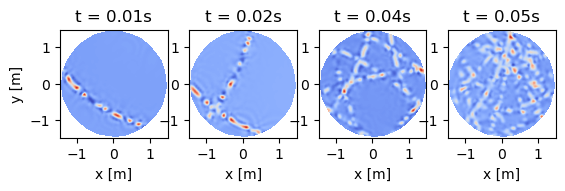

In [4]:
rirdata = data['reference_data']
fs = data['fs']
grid = data['grid_reference']
t_test1 = int(fs*0.015)
t_test2 = int(fs*0.02)
t_test3 = int(fs*0.035)
t_test4 = int(fs*0.05)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax1, _ = plot_sf(rirdata[:, t_test1], grid[0], grid[1], ax = ax1, name = 't = {:.2f}s'.format(t_test1/fs))
ax2, _ = plot_sf(rirdata[:, t_test2], grid[0], grid[1], ax = ax2,  name = 't = {:.2f}s'.format(t_test2/fs))
ax3, _ = plot_sf(rirdata[:, t_test3], grid[0], grid[1], ax = ax3,  name = 't = {:.2f}s'.format(t_test3/fs))
ax4, _ = plot_sf(rirdata[:, t_test4], grid[0], grid[1], ax = ax4,  name = 't = {:.2f}s'.format(t_test4/fs))
for ax in (ax2, ax3, ax4):
    ax.set_ylabel('')
fig.show()

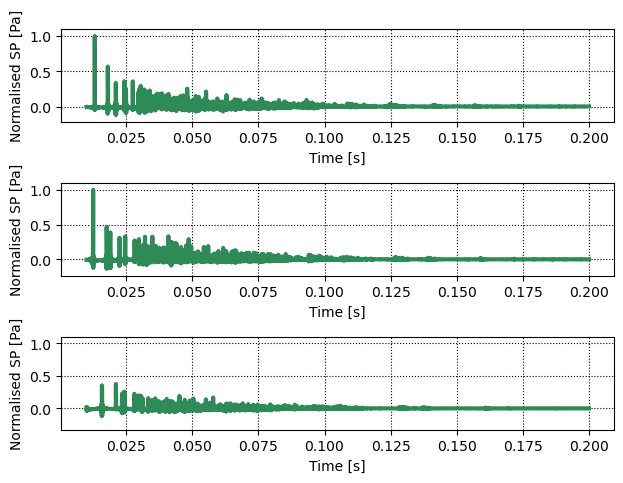

In [5]:
fig, ax = plt.subplots(3, 1)
ax[0] = plot_rir(rirdata[4], ax = ax[0])
ax[1] = plot_rir(rirdata[254], ax = ax[1])
ax[2] = plot_rir(rirdata[888], ax = ax[2])
fig.tight_layout()
plt.show()

## Prepare Data

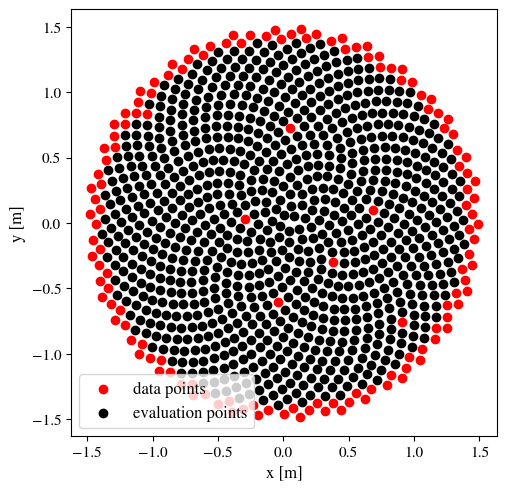

In [61]:
data = rirdata[:, int(0.25*fs)] # truncate
t = np.linspace(0, 0.25, int(0.25*fs)) # Does not need normalisation if < 1 second
t_ind = np.arange(0, int(0.25*fs))
x_true = grid[0]
y_true = grid[1]
# boundary indices
boundary_ind = np.argwhere(x_true**2 + y_true**2 > (1.4)**2)
# regular point indices
mask = np.ones(grid.shape[1], dtype=bool)
mask[boundary_ind] = False
reg_ind = np.argwhere(mask == True)
# random interpolation indices
interp_indx = np.random.choice(reg_ind.squeeze(-1), 7, replace=False)# Randomly chosen points for Interior
# add to boundary indices
data_ind = np.vstack((boundary_ind, interp_indx[..., None])).squeeze(-1)
# regular point grid
mask = np.ones(grid.shape[1], dtype=bool)
mask[data_ind] = False
grid_rest = grid[:, mask]
# plot data points (spatial data points only e.g. not regarding time)
plt.scatter(grid[0, data_ind], grid[1, data_ind], color = 'red')
plt.scatter(grid_rest[0], grid_rest[1], color = 'k')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.legend(['data points', 'evaluation points'])
plt.gca().set_aspect('equal')
plt.show()

In [62]:
x = x_true/1.5 #feature scaling
y = y_true/1.5 #feature scaling
coords_full = [x, y, t]

In [63]:
# Domain bounds
bounds = [1.5, 1.]

## Training Data

In [64]:
total_points=len(x)*len(y)*len(t)
total_training_points =len(x[data_ind])*len(y[data_ind])*len(t)
total_bc_points =len(x[boundary_ind])*len(y[boundary_ind])*len(t)
print("We have",total_points,"points in total. We will select",total_training_points,"points to train our model (data term) and",total_bc_points,"for the boundary condition enforcement.")

We have 4000000000 points in total. We will select 73984000 points to train our model (data term) and 66564000 for the boundary condition enforcement.


In [82]:
# Obtain points for interior
tfnp = lambda x : torch.from_numpy(x).float().to(device)

TrainPositions = [tfnp(x_true[data_ind]), tfnp(y_true[data_ind]), tfnp(t[t_ind])]
BCPositions = [tfnp(x_true[boundary_ind]), tfnp(y_true[boundary_ind]), tfnp(t[t_ind])]
EvalPositions = [tfnp(x_true), tfnp(y_true), tfnp(t[t_ind])]

TrainData = rirdata[data_ind]
TrainData = tfnp(TrainData[:, t_ind])

In [83]:
print("Original shapes for grid and pressure:",grid.shape,rirdata.shape)
print("Final training data:",grid[:, data_ind].shape,TrainData.shape)

Original shapes for grid and pressure: (3, 1000) (1000, 16384)
Final training data: (3, 136) torch.Size([136, 4000])


# Train Neural Network

In [ ]:
TrainPositions = torch.from_numpy(TrainPositions).float().to(device)
BCPositions = torch.from_numpy(BCPositions).float().to(device)
BCPositions = torch.from_numpy(BCPositions).float().to(device)
U_train_Nu = torch.from_numpy(U_train_Nu).float().to(device)
X_true = torch.from_numpy(X_true).float().to(device)
U_true = torch.from_numpy(U_true).float().to(device)
f_hat = torch.zeros(X_train_Nu.shape[0],1).to(device)

In [ ]:
layers = np.array([2,20,20,20,20,20,20,20,20,1]) #8 hidden layers

In [ ]:
PINN = FCN(layers)
       
PINN

'Neural Network Summary'
print(PINN)

params = list(PINN.dnn.parameters())

'''Optimization'''

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              history_size = 100, 
                              line_search_fn = 'strong_wolfe')

start_time = time.time()

optimizer.step(PINN.closure)
    
    
elapsed = time.time() - start_time                
print('Training time: %.2f' % (elapsed))


''' Model Accuracy ''' 
error_vec, u_pred = PINN.test()

print('Test Error: %.5f'  % (error_vec))

Relative Error(Test): 0.40038 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.10995,  0.00180]
Relative Error(Test): 0.27630 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.10895,  0.00209]
Relative Error(Test): 0.25630 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.16387,  0.00214]
Relative Error(Test): 0.22366 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.40723,  0.00628]
Relative Error(Test): 0.20818 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.48434,  0.00725]
Relative Error(Test): 0.19597 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.50651,  0.00540]
Relative Error(Test): 0.18228 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.57998,  0.00618]
Relative Error(Test): 0.17167 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.58211,  0.00498]
Relative Error(Test): 0.16647 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.57235,  0.00419]
Relative Error(Test): 0.14306 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.69912,  0.00637]
Relative Error(Test): 0.13283 , 𝜆_real = [1.0,  0.00318], 𝜆_PINN = [0.71367,  0.00532]
Relative Error(Test): 0.12728 , 𝜆_real = [1

# Plots

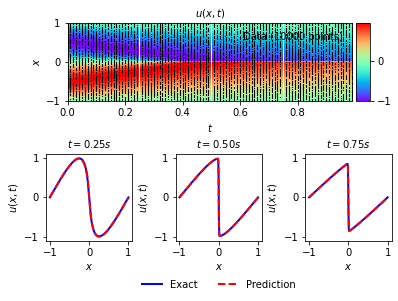

In [ ]:
solutionplot(u_pred,X_train_Nu.cpu().detach().numpy(),U_train_Nu)

In [ ]:
x1=X_true[:,0]
t1=X_true[:,1]

In [ ]:
arr_x1=x1.reshape(shape=X.shape).transpose(1,0).detach().cpu()
arr_T1=t1.reshape(shape=X.shape).transpose(1,0).detach().cpu()

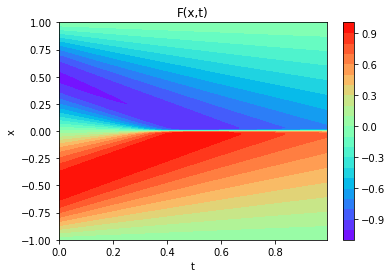

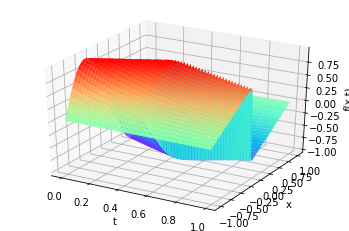

In [ ]:
plot3D_Matrix(arr_x1,arr_T1,torch.from_numpy(u_pred))

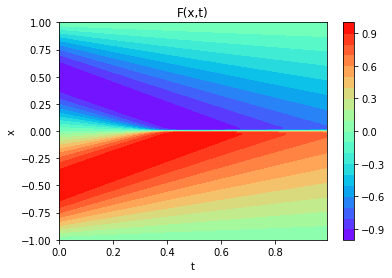

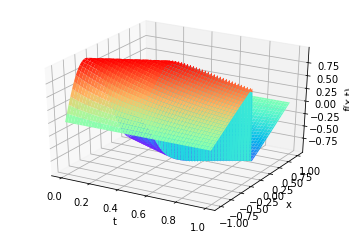

In [ ]:
plot3D(torch.from_numpy(x),torch.from_numpy(t),torch.from_numpy(usol)) 

## References:


[1] Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics informed deep learning (part i): Data-driven solutions of nonlinear partial differential equations. arXiv preprint arXiv:1711.10561. http://arxiv.org/pdf/1711.10561v1

[2] Lu, L., Meng, X., Mao, Z., & Karniadakis, G. E. (1907). DeepXDE: A deep learning library for solving differential equations,(2019). URL http://arxiv. org/abs/1907.04502. https://arxiv.org/abs/1907.04502

[3] Rackauckas Chris, Introduction to Scientific Machine Learning through Physics-Informed Neural Networks. https://book.sciml.ai/notes/03/

[4] Repository: Physics-Informed-Neural-Networks (PINNs).https://github.com/omniscientoctopus/Physics-Informed-Neural-Networks/tree/main/PyTorch/Burgers'%20Equation

[5]  Raissi, M., Perdikaris, P., & Karniadakis, G. E. (2017). Physics Informed Deep Learning (part ii): Data-driven Discovery of Nonlinear Partial Differential Equations. arXiv preprint arXiv:1711.10566. https://arxiv.org/abs/1711.10566

[6] Repository: PPhysics-Informed Deep Learning and its Application in Computational Solid and Fluid Mechanics.https://github.com/alexpapados/Physics-Informed-Deep-Learning-Solid-and-Fluid-Mechanics.

